In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Explore basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())
print(train_df.info())

Train shape: (891, 12)
Test shape: (418, 11)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0  

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_data(df):
    # Fill missing Age with median
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # Fill missing Embarked with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # For test set, if Fare is missing, fill with median
    if 'Fare' in df.columns:
        df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Convert categorical columns
    le = LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    df['Embarked'] = le.fit_transform(df['Embarked'])
    
    # Drop columns that won't be used in the model
    df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

print(train_df.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0            1         0       3    1  22.0      1      0   7.2500         2
1            2         1       1    0  38.0      1      0  71.2833         0
2            3         1       3    0  26.0      0      0   7.9250         2
3            4         1       1    0  35.0      1      0  53.1000         2
4            5         0       3    1  35.0      0      0   8.0500         2


<ipython-input-3-7ba412fb87ee>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-3-7ba412fb87ee>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [4]:
# Separating features and target in training data
X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']

# Test data features (keep PassengerId for submission)
X_test = test_df.drop(['PassengerId'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    return model

model = build_model(X_scaled.shape[1])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4563 - loss: 0.7227 - val_accuracy: 0.7263 - val_loss: 0.6338
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6419 - loss: 0.6728 - val_accuracy: 0.7207 - val_loss: 0.5781
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7177 - loss: 0.6014 - val_accuracy: 0.7933 - val_loss: 0.5159
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6934 - loss: 0.5949 - val_accuracy: 0.8268 - val_loss: 0.4674
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7321 - loss: 0.5520 - val_accuracy: 0.8212 - val_loss: 0.4332
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7586 - loss: 0.5193 - val_accuracy: 0.8268 - val_loss: 0.4128
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7487 - loss: 0.5290 - val_accuracy: 0.8268 - val_loss: 0.4048
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7720 - loss: 0.5356 - val_accuracy: 0.8324 - v

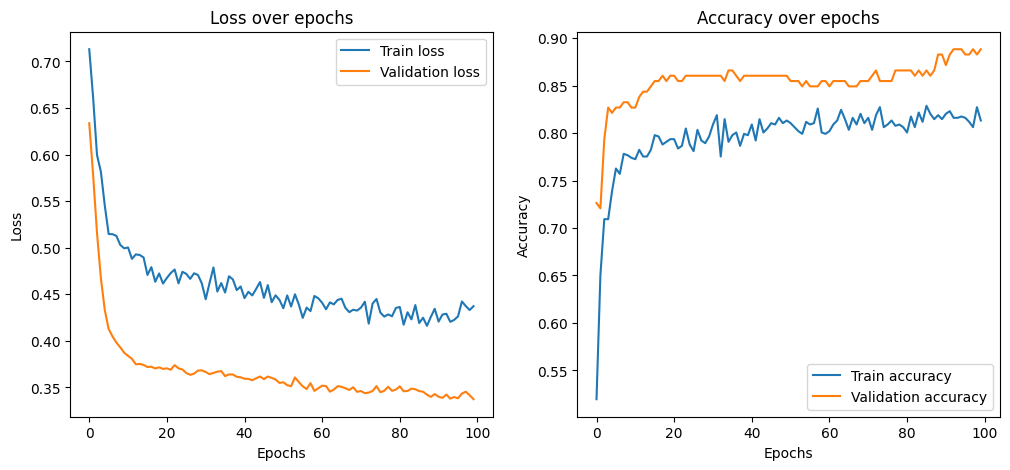

In [6]:
# Train the model
history = model.fit(X_scaled, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Plot training & validation loss and accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [7]:
# Predict probabilities and convert to 0 or 1
predictions = model.predict(X_test_scaled)
predictions = (predictions > 0.5).astype(int).reshape(-1)

# Prepare submission dataframe
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": predictions})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Submission file created!
